# Lesson 12.1 深度学习建模实验中数据集生成函数的创建与使用      

&emsp;&emsp;为了方便后续练习的展开，我们尝试自己创建一个数据生成器，用于自主生成一些符合某些条件、具备某些特性的数据集。相比于传统的机器学习领域，深度学习的数据集往往更加复杂，大多数情况也无法把数据生成数据表来进行查看，在建模过程中，往往都是设计完模型结构后直接训练模型，只能通过一些指标来观测模型的效果，外加复杂神经网络内部其实也是“黑箱”，因此我们基本只能控制流程、输入数据、观测结果，说是炼丹师也并不为过。不过在学习阶段，尤其在学习优化算法的过程，我们还是希望能够从更多角度观测数据、观测建模过程，这就需要我们自己动手，创建一些数据用于实验的原材料，通过一些实验深入了解模型原理，从“炼丹师”朝着“化学家”更进一步。

- 导入相关的包

In [48]:
# 随机模块
import random

# 绘图模块
import matplotlib as mpl
import matplotlib.pyplot as plt

# numpy
import numpy as np

# pytorch
import torch
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import Dataset,TensorDataset,DataLoader

> 以上均为此前用到的包，其他的新的包将在使用时再进行导入及介绍

## 一、回归类数据集创建方法

### 1.手动生成数据

&emsp;&emsp;回归类模型的数据，特征和标签都是连续型数值。

> 正常情况，应该是对于连续型数值标签的预测，我们采用回归类模型，此处因为先生成数据后进行建模，因此我们称可用于回归模型训练的数据为回归类模型数据，分类模型数据亦然。

- 数据生成

生成两个特征、存在偏差，自变量和因变量存在线性关系的数据集

In [49]:
num_inputs = 2               # 两个特征
num_examples = 1000          # 总共一千条数据

然后尝试通过线性方程，确定自变量和因变量的真实关系

In [50]:
torch.manual_seed(420)       # 设置随机数种子

In [51]:
# 线性方程系数
w_true = torch.tensor([2., -1]).reshape(2, 1)
b_true = torch.tensor(1.)

# 特征和标签取值
features = torch.randn(num_examples, num_inputs)
labels_true = torch.mm(features, w_true) + b_true
labels = labels_true + torch.randn(size = labels_true.shape) * 0.01

> 此处设置所有的数据都是浮点型。

注意，此时labels_true和features满足严格意义上的线性方程关系

$$y = 2x_1-x_2+1$$

但我们实际使用的标签labels，则是在labels_true的基础上增添了一个扰动项，`torch.randn(size = labels_true.shape) * 0.01`，这其实也符合我们一般获取数据的情况：真实客观世界或许存在某个规律，但我们搜集到的数据往往会因为各种原因存在一定的误差，无法完全描述真实世界的客观规律，这其实也是模型误差的来源之一（另一个误差来源是模型本身捕获规律的能力）。这其中，$y=2x_1-x_2+1$相当于我们从上帝视角创建的数据真实服从的规律，而扰动项，则相当于人为创造的获取数据时的误差。  

> 这种按照某种规律生成数据、又人为添加扰动项的创建数据的方法，也是数学领域创建数据的一般方法。

- 数据探索

In [52]:
features[: 10]

tensor([[-0.0070,  0.5044],
        [ 0.6704, -0.3829],
        [ 0.0302,  0.3826],
        [-0.5131,  0.7104],
        [ 1.8092,  0.4352],
        [ 2.6453,  0.2654],
        [ 0.9235, -0.4376],
        [ 2.0182,  1.3498],
        [-0.2523, -0.0355],
        [-0.0646, -0.5918]])

In [53]:
labels[: 10]

tensor([[ 0.4735],
        [ 2.7285],
        [ 0.6764],
        [-0.7537],
        [ 4.1722],
        [ 6.0236],
        [ 3.2936],
        [ 3.6706],
        [ 0.5282],
        [ 1.4557]])

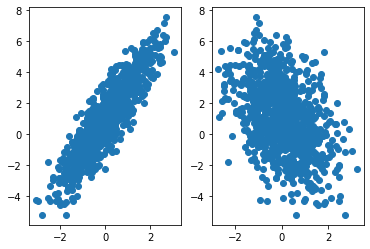

In [15]:
plt.subplot(121)
plt.scatter(features[:, 0], labels)          # 第一个特征和标签的关系
plt.subplot(122)
plt.scatter(features[:, 1], labels)          # 第二个特征和标签的关系

不难看出，两个特征和标签都存在一定的线性关系，并且跟特征的系数绝对值有很大关系。当然，若要增加线性模型的建模难度，可以增加扰动项的数值比例，从而削弱线性关系。

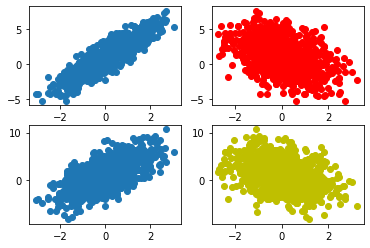

In [21]:
# 设置随机数种子
torch.manual_seed(420)   

# 修改因变量
labels1 = labels_true + torch.randn(size = labels_true.shape) * 2

# 可视化展示

# 扰动较小的情况
plt.subplot(221)
plt.scatter(features[:, 0], labels)             # 第一个特征和标签的关系
plt.subplot(222)
plt.plot(features[:, 1], labels, 'ro')          # 第二个特征和标签的关系

# 扰动较大的情况
plt.subplot(223)
plt.scatter(features[:, 0], labels1)             # 第一个特征和标签的关系
plt.subplot(224)
plt.plot(features[:, 1], labels1, 'yo')          # 第二个特征和标签的关系

当然，我们也能生成非线性关系的数据集，此处我们创建满足$y=x^2+1$规律的数据集。

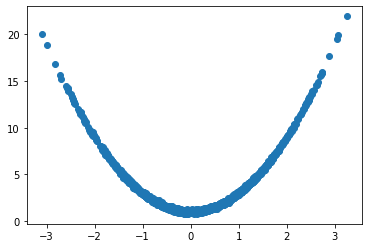

In [49]:
# 设置随机数种子
torch.manual_seed(420)   

num_inputs = 2               # 两个特征
num_examples = 1000          # 总共一千条数据

# 线性方程系数
w_true = torch.tensor(2.)
b_true = torch.tensor(1.)

# 特征和标签取值
features = torch.randn(num_examples, num_inputs)
labels_true = torch.pow(features, 2) * w_true + b_true
labels = labels_true + torch.randn(size = labels_true.shape) * 0.1

# 可视化展示
plt.scatter(features, labels)

### 2.创建生成回归类数据的函数

&emsp;&emsp;为了方便后续使用，我们将上述过程封装在一个函数内

- 定义创建函数

In [54]:
def tensorGenReg(num_examples = 1000, w = [2, -1, 1], bias = True, delta = 0.01, deg = 1):
    """回归类数据集创建函数。

    :param num_examples: 创建数据集的数据量
    :param w: 包括截距的（如果存在）特征系数向量
    :param bias：是否需要截距
    :param delta：扰动项取值
    :param deg：方程次数
    :return: 生成的特征张和标签张量
    """
    
    if bias == True:
        num_inputs = len(w)-1                                                        # 特征张量
        features_true = torch.randn(num_examples, num_inputs)                        # 不包含全是1的列的特征张量
        w_true = torch.tensor(w[:-1]).reshape(-1, 1).float()                         # 自变量系数
        b_true = torch.tensor(w[-1]).float()                                         # 截距
        if num_inputs == 1:                                                          # 若输入特征只有1个，则不能使用矩阵乘法
            labels_true = torch.pow(features_true, deg) * w_true + b_true
        else:
            labels_true = torch.mm(torch.pow(features_true, deg), w_true) + b_true
        features = torch.cat((features_true, torch.ones(len(features_true), 1)), 1)  # 在特征张量的最后添加一列全是1的列
        labels = labels_true + torch.randn(size = labels_true.shape) * delta         
                
    else: 
        num_inputs = len(w)
        features = torch.randn(num_examples, num_inputs)
        w_true = torch.tensor(w).reshape(-1, 1).float()
        if num_inputs == 1:
            labels_true = torch.pow(features, deg) * w_true
        else:
            labels_true = torch.mm(torch.pow(features, deg), w_true)
        labels = labels_true + torch.randn(size = labels_true.shape) * delta
    return features, labels

> 注：上述函数无法创建带有交叉项的方程

- 测试函数性能

首先查看扰动项较小的时候的数据情况

In [25]:
# 设置随机数种子
torch.manual_seed(420)   

# 扰动项取值为0.01
f, l = tensorGenReg(delta=0.01)

f

tensor([[-0.0070,  0.5044,  1.0000],
        [ 0.6704, -0.3829,  1.0000],
        [ 0.0302,  0.3826,  1.0000],
        ...,
        [-0.9164, -0.6087,  1.0000],
        [ 0.7815,  1.2865,  1.0000],
        [ 1.4819,  1.1390,  1.0000]])

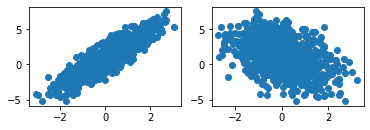

In [26]:
# 绘制图像查看结果
plt.subplot(223)
plt.scatter(f[:, 0], l)             # 第一个特征和标签的关系
plt.subplot(224)
plt.scatter(f[:, 1], l)          # 第二个特征和标签的关系

然后查看扰动项较大时数据情况

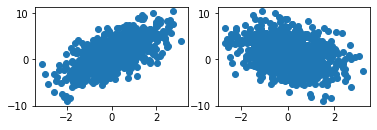

In [27]:
# 设置随机数种子
torch.manual_seed(420)   

# 扰动项取值为2
f, l = tensorGenReg(delta=2)

# 绘制图像查看结果
plt.subplot(223)
plt.scatter(f[:, 0], l)             # 第一个特征和标签的关系
plt.subplot(224)
plt.scatter(f[:, 1], l)          # 第二个特征和标签的关系

当特征和标签满足二阶关系时候数据表现

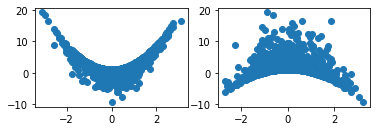

In [28]:
# 设置随机数种子
torch.manual_seed(420)   

# 2阶方程
f, l = tensorGenReg(deg=2)

# 绘制图像查看结果
plt.subplot(223)
plt.scatter(f[:, 0], l)             # 第一个特征和标签的关系
plt.subplot(224)
plt.scatter(f[:, 1], l)          # 第二个特征和标签的关系

当只有一个特征时数据表现

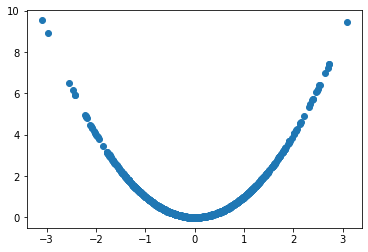

In [29]:
# 设置随机数种子
torch.manual_seed(420)   

# 2阶方程
f, l = tensorGenReg(w=[1], deg=2, bias=False)
plt.scatter(f, l)

## 二、分类数据集创建方法

&emsp;&emsp;和回归模型的数据不同，分类模型数据的标签是离散值。

### 1.手动创建分类数据集

- 数据生成

在尝试创建分类数据集之前，首先回顾torch.normal创建某种服从正态分布的随机数的创建方法。

In [55]:
torch.randn(4, 2)

tensor([[ 1.4000,  0.3924],
        [-0.0695, -1.7610],
        [ 0.3227,  1.7285],
        [-0.1107, -1.6273]])

In [30]:
torch.normal(4, 2, size=(10,2))

tensor([[4.8092, 0.9773],
        [4.4092, 3.3987],
        [1.7446, 6.2281],
        [3.0095, 4.2286],
        [7.8873, 6.5354],
        [3.9286, 4.0315],
        [2.0309, 4.5259],
        [3.6491, 0.7394],
        [3.6549, 5.4767],
        [8.5935, 3.0440]])

接下来尝试创建一个拥有两个特征的三分类的数据集，每个类别包含500条数据，并且第一个类别的两个特征都服从均值为4、标准差为2的正态分布，第二个类别的两个特征都服从均值为-2、标准差为2的正态分布，第三个类别的两个特征都服从均值为-6、标准差为2的正态分布，创建过程如下:

In [31]:
# 设置随机数种子
torch.manual_seed(420)   

# 创建初始标记值
num_inputs = 2
num_examples = 500

# 创建自变量簇
data0 = torch.normal(4, 2, size=(num_examples, num_inputs))
data1 = torch.normal(-2, 2, size=(num_examples, num_inputs))
data2 = torch.normal(-6, 2, size=(num_examples, num_inputs))

# 创建标签
label0 = torch.zeros(500)
label1 = torch.ones(500)
label2 = torch.full_like(label1, 2)

# 合并生成最终数据
features = torch.cat((data0, data1, data2)).float()
labels = torch.cat((label0, label1, label2)).long().reshape(-1, 1)

此处需要注意：
- normal函数的均值参数位、标准差参数位都允许输入高维数组，从而最终输出结果也是形状相同的高维数组；
- 一般来说，约定俗成的方式，是针对多分类问题，类别标记从0开始依次递增；
- 对于PyTorch来说，分类问题标签要求是默认整型。

- 数据探索

In [36]:
features[: 10]

tensor([[3.9859, 5.0089],
        [5.3407, 3.2343],
        [4.0605, 4.7653],
        [2.9738, 5.4208],
        [7.6183, 4.8705],
        [9.2907, 4.5307],
        [5.8470, 3.1249],
        [8.0364, 6.6997],
        [3.4954, 3.9290],
        [3.8709, 2.8165]])

In [37]:
labels[: 10]

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])

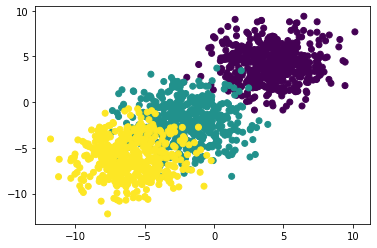

In [53]:
# 可视化展示
plt.scatter(features[:, 0], features[:, 1], c = labels)

能够看出，类别彼此交叉情况较少，分类器在此数据集上会有不错表现。当然，若要增加分类器的分类难度，可以将各类的均值压缩，并增加方差，从而增加从二维图像上来看彼此交错的情况。

In [38]:
# 设置随机数种子
torch.manual_seed(420)   

# 创建初始标记值
num_inputs = 2
num_examples = 500

# 创建自变量簇
data0 = torch.normal(3, 2, size=(num_examples, num_inputs))
data1 = torch.normal(0, 2, size=(num_examples, num_inputs))
data2 = torch.normal(-3, 2, size=(num_examples, num_inputs))

# 创建标签
label0 = torch.zeros(500)
label1 = torch.ones(500)
label2 = torch.full_like(label1, 2)

# 合并生成最终数据
features1 = torch.cat((data0, data1, data2)).float()
labels1 = torch.cat((label0, label1, label2)).long().reshape(-1, 1)

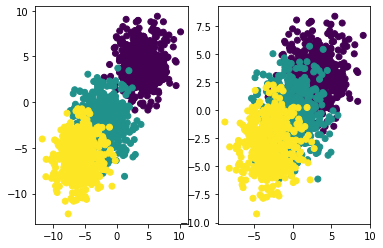

In [43]:
# 可视化展示
plt.subplot(121)
plt.scatter(features[:, 0], features[:, 1], c = labels)             
plt.subplot(122)
plt.scatter(features1[:, 0], features1[:, 1], c = labels1)

### 2.创建生成分类数据的函数

&emsp;&emsp;同样，我们将上述创建分类函数的过程封装为一个函数。这里需要注意的是，我们希望找到一个变量可以控制数据整体离散程度，也就是后续建模的难以程度。这里我们规定，如果每个分类数据集中心点较近、且每个类别的点内部方差较大，则数据集整体离散程度较高，反之离散程度较低。在实际函数创建过程中，我们也希望能够找到对应的参数能够方便进行自主调节。

- 定义创建函数

In [56]:
def tensorGenCla(num_examples = 500, num_inputs = 2, num_class = 3, deg_dispersion = [4, 2], bias = False):
    """分类数据集创建函数。
    
    :param num_examples: 每个类别的数据数量
    :param num_inputs: 数据集特征数量
    :param num_class：数据集标签类别总数
    :param deg_dispersion：数据分布离散程度参数，需要输入一个列表，其中第一个参数表示每个类别数组均值的参考、第二个参数表示随机数组标准差。
    :param bias：建立模型逻辑回归模型时是否带入截距
    :return: 生成的特征张量和标签张量，其中特征张量是浮点型二维数组，标签张量是长正型二维数组。
    """
    
    cluster_l = torch.empty(num_examples, 1)                         # 每一类标签张量的形状
    mean_ = deg_dispersion[0]                                        # 每一类特征张量的均值的参考值
    std_ = deg_dispersion[1]                                         # 每一类特征张量的方差
    lf = []                                                          # 用于存储每一类特征张量的列表容器
    ll = []                                                          # 用于存储每一类标签张量的列表容器
    k = mean_ * (num_class-1) / 2                                    # 每一类特征张量均值的惩罚因子（视频中部分是+1，实际应该是-1）
    
    for i in range(num_class):
        data_temp = torch.normal(i*mean_-k, std_, size=(num_examples, num_inputs))     # 生成每一类张量
        lf.append(data_temp)                                                           # 将每一类张量添加到lf中
        labels_temp = torch.full_like(cluster_l, i)                                    # 生成类一类的标签
        ll.append(labels_temp)                                                         # 将每一类标签添加到ll中
        
    features = torch.cat(lf).float()
    labels = torch.cat(ll).long()
    
    if bias == True:
        features = torch.cat((features, torch.ones(len(features), 1)), 1)              # 在特征张量中添加一列全是1的列
    return features, labels

In [ ]:
[0, 4, 8]     ->     [-4, 0, 4]    -> [-1, 0 ,1]
[0, 4, 8, 12, 16]     ->       [-8, -4, 0, 4, 8]      ->        [-2, -1, 0, 1, 2]

&emsp;&emsp;函数整体结构不复杂，且所使用的方法都是此前介绍过的tensor常用方法，唯一需要注意的是函数对于分布离散程度的控制。函数内部变量k是一个随着均值增加和分类类别数量增加而增加的数值，且分类数量增加对k值增加影响是通过和1取平均后进行惩罚的结果。而i*mean_则是一个随着i增加稳步增量的量，二者相减最终能获得一个整体特征均匀分布在0附近的特征张量。

- 测试函数性能

在使用函数的过程中，离散度的第一个数值可以理解为簇的大概分布区间，第二个数值可以理解为每个簇的离散程度。

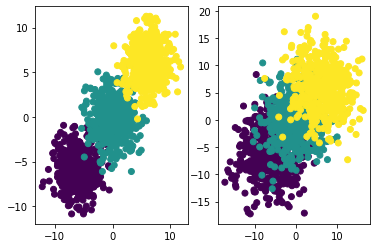

In [57]:
# 设置随机数种子
torch.manual_seed(420)   

# 创建数据
f, l = tensorGenCla(deg_dispersion = [6, 2])          # 离散程度较小
f1, l1 = tensorGenCla(deg_dispersion = [6, 4])        # 离散程度较大

# 绘制图像查看
plt.subplot(121)
plt.scatter(f[:, 0], f[:, 1], c = l)
plt.subplot(122)
plt.scatter(f1[:, 0], f1[:, 1], c = l1)

## 三、创建小批量切分函数

&emsp;&emsp;在深度学习建模过程中，梯度下降是最常用的求解目标函数的优化方法，而针对不同类型、拥有不同函数特性的目标函数，所使用的梯度下降算法也各有不同。目前为止，我们判断小批量梯度下降（MBGD）是较为“普适”的优化算法，它既拥有随机梯度下降（SGD）的能够跨越局部最小值点的特性，同时又和批量梯度下降（BGD）一样，拥有相对较快的收敛速度（虽然速度略慢与BGD）。而在小批量梯度下降过程中，我们需要对函数进行分批量的切分，因此，在手动实现各类深度学习基础算法之前，我们需要定义数据集小批量切分的函数。

> 另外，后续讲解的交叉验证计算过程也需要对数据进行切分

shuffle过程：将原序列乱序排列

In [60]:
l = list(range(5))
l

[0, 1, 2, 3, 4]

In [61]:
random.shuffle(l)
l

[3, 2, 0, 1, 4]

批量切分函数的目标就是根据设置的“批数”，将原数据集随机均匀切分。可通过如下函数实现：

In [68]:
def data_iter(batch_size, features, labels):
    """
    数据切分函数
    
    :param batch_size: 每个子数据集包含多少数据
    :param featurs: 输入的特征张量
    :param labels：输入的标签张量
    :return l：包含batch_size个列表，每个列表切分后的特征和标签所组成 
    """
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    l = []
    for i in range(0, num_examples, batch_size):
        j = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        l.append([torch.index_select(features, 0, j), torch.index_select(labels, 0, j)])
    return l

In [66]:
for i in range(0, 5, 2):
    print(i)

0
2
4


In [58]:
# 设置随机数种子
torch.manual_seed(420)  

# 生成二分类数据集
features, labels = tensorGenCla()       

In [65]:
features[:5]

tensor([[-4.0141, -2.9911],
        [-2.6593, -4.7657],
        [-3.9395, -3.2347],
        [-5.0262, -2.5792],
        [-0.3817, -3.1295]])

In [64]:
torch.tensor(l[0:2])

tensor([3, 2])

In [63]:
torch.index_select(features, 0, torch.tensor(l[0:2]))

tensor([[-5.0262, -2.5792],
        [-3.9395, -3.2347]])

In [72]:
labels

tensor([[0],
        [0],
        [0],
        ...,
        [2],
        [2],
        [2]])

In [69]:
l = data_iter(10, features, labels)

In [70]:
l[0]                                     # 查看切分后的第一个数据集 

[tensor([[ 0.7901,  2.4304],
         [ 4.0788,  3.7885],
         [-1.1552, -0.8829],
         [ 1.3738,  2.3689],
         [-2.1479, -6.6638],
         [-2.5418, -7.9962],
         [-1.0777, -0.7594],
         [ 5.6215,  3.9071],
         [ 3.5896,  3.3644],
         [ 1.2458,  0.0179]]),
 tensor([[1],
         [2],
         [1],
         [1],
         [0],
         [0],
         [1],
         [2],
         [2],
         [1]])]

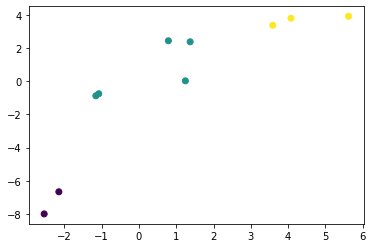

In [71]:
plt.scatter(l[0][0][:, 0], l[0][0][:, 1], c = l[0][1])

> 此处又使用了空列表用于存储数据。在经典机器学习领域，我们经常使用空的列表来存储经过处理之后的数据，这么做能让我们非常清楚的看到数据的真实情况，但在深度学习领域，这么做却不是常规操作。在深度学习领域，数据量往往非常大，甚至数据本身就是分布式存储的，要调取数据进行完整的查看，一方面会耗费大量的存储空间，另一方面也会消耗一定的算力，因此PyTorch的Dataset和DataLoader都是将数据进行迭代存储或者映射存储。关于数据生成器大的相关内容我们将在后续进行讨论，此处由于我们是进行手动实验，将处理完的数据完整的存在列表容器中则是为了方便调用查看，是一种更适合初学者的方法。

### 四、Python模块编写

根据此前介绍的课程安排，本节定义的函数将后续课程中将经常使用，因此需要将其封装为一个模块方便后续调用。封装为模块有以下几种基本方法：      
- 打开文本编辑器，将写好并测试完成的函数写入其中，并将文本的拓展名改写为.py；      
- 在spyder或者pycharm中复制相关函数，并保存为.py文件；      

然后将文件保存在jupyter主目录下，并取名为torchLearning，后续即可通过import torchLearning进行调用。如果是jupyterlab用户，也可按照如下方式进行编写：

Step 1.打开左侧文件管理栏页，点击新建

<img src="https://i.loli.net/2021/02/06/FboP4hg3xZ5rGnV.jpg" alt="40" style="zoom:40%;" />

Step 2.在新建目录中，选择Test File

<img src="https://i.loli.net/2021/02/06/QzPKTxce8wynYq4.jpg" alt="41" style="zoom:50%;" />

Step 3.在打开的文本编辑器中输入代码

<img src="https://i.loli.net/2021/02/06/Mi5LCn6SW4DfPE2.jpg" alt="40" style="zoom:40%;" />

需要保存的函数有：
- tensorGenReg函数
- tensorGenCla函数
- data_iter函数

Step 4.保存退出，并将文件名改写为torchLearning.py

<img src="https://i.loli.net/2021/02/06/QSC1HYvJg9Zq7T5.jpg" alt="43" style="zoom:33%;" />

然后即可在其他ipy文件中调用，具体调用方法见下一节内容。